from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

In [2]:
# G = nx.read_graphml('../data/structural_clusters_network.graphml')
G = nx.read_graphml('/global/homes/b/bpb/repos/scndb/build/CarbonNetwork.graphml')
df = dict(G.nodes(data=True))
df = pd.DataFrame(df).T
df.index.name = 'node_id'
df.reset_index(inplace=True,drop=False)
df.to_csv('CarbonNetwork-NodeData.csv',index=None)
print(df.shape)
df.columns

(7359, 48)


Index(['node_id', 'original_index', 'massive_id', 'no_extension_basename',
       'precursor_mz', 'isolated_precursor_mz', 'rt',
       'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr',
       'predicted_mass', 'mass_error', 'num_mdm_frags', 'max_score_identity',
       'best_match_method_identity', 'max_matches_identity', 'name_identity',
       'inchi_key_identity', 'smiles_identity', 'formula_identity',
       'precursor_mz_identity', 'original_p2d2_index_identity',
       'isin_fticr_formula', 'dbe', 'dbe_ai', 'dbe_ai_mod', 'ai_mod', 'ai',
       'nosc', 'h_to_c', 'o_to_c', 'n_to_c', 'p_to_c', 'c', 'h', 'o', 'n', 's',
       'p', 'class_results', 'superclass_results', 'pathway_results',
       'class_results_propagated', 'superclass_results_propagated',
       'pathway_results_propagated', 'title', 'description', 'n_to_p'],
      dtype='object')

In [3]:
file = '/global/cfs/cdirs/metatlas/raw_data/egsb/20231113_EB_SMK_107002-011_CenturyExp_20230414_EXP120A_C18-EP_USDAY72349'
files = glob.glob(os.path.join(file,'*NEG*.h5'))
files = [f for f in files if not 'exctrl' in f.lower()]
files = [f for f in files if not 'qc' in f.lower()]
# files = [f for f in files if  'sunshine' in f.lower()]
# files = [f for f in files if ('water' in f) | ('MeOH' in f)]


files = pd.DataFrame(files,columns=['filename'])
# files = files[files['filename'].isin(files_to_use)]
files['experiment'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
files['sampletype'] = files['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
# # files['sampletype'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[12:15]))
# print(files['experiment'].unique())
# # experiments = ['Permafrost_pilot', 'SoilWetDry_final',
#        # 'GEODES_All3', 'FRCgw2_20230830','OMTSoil50g_Pilot']
# # files = files[files['experiment'].isin(experiments)]
files['sampletype'].unique()

files
# files

,filename,experiment,sampletype
0,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm
1,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-OMT-2d3-00to20cm
2,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-8d6-00to20cm
3,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-RWC-3d9-40to60cm
4,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm
...,...,...,...
105,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-RWC-3d9-00to20cm
106,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-OMT-6d4-40to60cm
107,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-OMT-2d3-00to20cm
108,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-UNBDP-2d1-40to60cm


In [ ]:
files[files['sampletype'].str.contains('UNBDP')]

In [4]:

ppm_tolerance = 5
mz_tol = 0.002
rt_min = 1
rt_max = 7

atlas = df[['node_id','precursor_mz']].copy()
atlas.rename(columns={'precursor_mz':'mz','node_id':'label'},inplace=True)
atlas['rt_min'] = rt_min
atlas['rt_max'] = rt_max
atlas['mz_tolerance'] = mz_tol
atlas['rt_tolerance'] = 100
atlas['ppm_tolerance'] = ppm_tolerance
atlas['extra_time'] = 0
atlas['rt_peak'] = (rt_min+rt_max)/2  
atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                    stepsize=ppm_tolerance,
                                    do_ppm=True)

out = []
counter = 0
for f in files['filename']:
    try:
        d = ft.get_atlas_data_from_file(f,atlas,desired_key='ms1_neg')
    except:
        print('Can not read',f)
        continue
    d = d[d['in_feature']==True].groupby('label').apply(ft.calculate_ms1_summary).reset_index()
    d['filename'] = f
    out.append(d)
    counter += 1
    print(counter)
out = pd.concat(out)
out.rename(columns={'label':'node_id'},inplace=True)

out

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename
0,0.0,29.0,1.509948e+06,188037.312500,200.128837,4.214752,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
1,1.0,522.0,3.171974e+06,30031.361328,163.039771,2.995543,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
2,10.0,910.0,1.524602e+07,104700.562500,165.019017,2.692523,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
3,100.0,40.0,3.013257e+05,18628.630859,153.018976,2.914312,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
4,10001.0,19.0,1.369569e+05,18861.298828,338.168683,5.526276,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
...,...,...,...,...,...,...,...
5449,9980.0,1.0,2.454811e+03,2454.810791,357.010815,2.326437,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
5450,9981.0,7.0,4.309381e+04,7828.748535,403.070553,5.127483,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
5451,9986.0,7.0,6.268361e+04,15028.955078,535.191306,5.152731,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...
5452,999.0,718.0,1.005394e+07,219550.421875,163.039725,2.996300,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...


In [5]:
out['experiment'] = out['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
out['sampletype'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
out['depth'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12].split('-')[-1])
out['environment'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12].split('-')[1])
out
# out['sampletype1'] = out['filename'].apply(lambda x: '-'.join(x.split('/')[-1].split('_')[12].split('-')[1:]))
# # out['sampletype2'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[14].split('-')[3])
# g = out.groupby('filename')['peak_area'].median()
# g.sort_values(ascending=False,inplace=True)
# g.head(20).to_csv('ones_that_are_big.csv')

,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename,experiment,sampletype,depth,environment
0,0.0,29.0,1.509948e+06,188037.312500,200.128837,4.214752,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
1,1.0,522.0,3.171974e+06,30031.361328,163.039771,2.995543,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
2,10.0,910.0,1.524602e+07,104700.562500,165.019017,2.692523,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
3,100.0,40.0,3.013257e+05,18628.630859,153.018976,2.914312,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
4,10001.0,19.0,1.369569e+05,18861.298828,338.168683,5.526276,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
...,...,...,...,...,...,...,...,...,...,...,...
5449,9980.0,1.0,2.454811e+03,2454.810791,357.010815,2.326437,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
5450,9981.0,7.0,4.309381e+04,7828.748535,403.070553,5.127483,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
5451,9986.0,7.0,6.268361e+04,15028.955078,535.191306,5.152731,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
5452,999.0,718.0,1.005394e+07,219550.421875,163.039725,2.996300,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT


In [ ]:
def setup_dataframe(out,use_classes=True):
    temp = out.copy()
    temp.fillna('unknown',inplace=True)
    if use_classes==True:
        d = temp.pivot_table(columns='filename',index=['class_results_propagated'],values='peak_area',aggfunc='mean',fill_value=300)
    else:
        d = temp.pivot_table(columns='filename',index=['node_id'],values='peak_area',aggfunc='mean',fill_value=300)

    # temp = d.T
    # temp.columns = [f"{index[1]}-{index[0]}" for index in temp.columns]
    d = d.apply(shannon_diversity_index,axis=0)
    d = d.to_frame()
    d.reset_index(inplace=True,drop=False)
    d.rename(columns={0:'shannon_diversity_index'},inplace=True)
    d['treatment'] = d['filename'].apply(lambda x: os.path.basename(x).split('_')[12].split('-')[1])
    d['depth'] = d['filename'].apply(lambda x: os.path.basename(x).split('_')[12].split('-')[-1])

    # Make treatment a categorical variable and put it in order
    c = ['unbdp', 'omt', 'grass', 'cmt', 'rwc']
    c = [cc.upper() for cc in c]
    d['treatment'] = pd.Categorical(d['treatment'], categories=c, ordered=True)
    return d


def shannon_diversity_index(m,threshold=1e5,q=2):
    m = m>threshold
    probabilities = m / m.sum()
    shannon_diversity_index = -np.sum(probabilities * np.log2(probabilities))
    return shannon_diversity_index
    # probabilities = m / m.sum()
    # hill_number = np.sum(probabilities**q)**(1/(1-q))
    # return hill_number

temp = pd.merge(out,df[['node_id','class_results_propagated']],on='node_id')
d = setup_dataframe(temp)
# Plot the boxplot
fig, ax = plt.subplots()
sns.boxplot(data=d, x='treatment', y='shannon_diversity_index', hue='depth', ax=ax)

# sns.boxplot(data=d, x='treatment', y='shannon_diversity_index', hue='depth', ax=ax, order=['unbdp', 'omt', 'grass', 'cmt', 'rwc'])

# fig,ax = plt.subplots()
# sns.boxplot(data=d,x='treatment',y='shannon_diversity_index',hue='depth',ax=ax)



KeyError: 'class_results_propagated'

In [7]:
d_sample = out.pivot_table(columns='node_id',index=['depth','environment'],values='peak_area',aggfunc='mean',fill_value=300)
# fig,ax = plt.subplots()
# d_sample.max().apply(np.log10).hist(ax=ax,bins=100,label='sample')

# idx = (max_sample>10000) & ((max_sample/min_sample)>5)

# d_sample = d_sample[max_sample[idx].index]
level1_values = d_sample.index.get_level_values(0).unique()
temp = d_sample[d_sample.index.get_level_values(0)==level1_values[0]]
min_sample = temp.min()
temp = temp - min_sample
max_sample = temp.max()
temp = temp / max_sample
d_sample[d_sample.index.get_level_values(0)==level1_values[0]] = temp

temp = d_sample[d_sample.index.get_level_values(0)==level1_values[1]]
min_sample = temp.min()
temp = temp - min_sample
max_sample = temp.max()
temp = temp / max_sample
d_sample[d_sample.index.get_level_values(0)==level1_values[1]] = temp


d_sample

node_id                    0.0       1.0      10.0     100.0   10001.0  \
depth    environment                                                     
00to20cm CMT          0.396534  1.000000  1.000000  1.000000  0.014947   
         GRASS        0.695573  0.574726  0.936725  0.957394  0.000000   
         OMT          0.000000  0.293056  0.165552  0.620600  1.000000   
         RWC          0.133983  0.000000  0.000000  0.540171  0.511546   
         UNBDP        1.000000  0.067477  0.296707  0.000000  0.913351   
40to60cm CMT          0.000000  0.860197  0.686636  0.890699  0.000000   
         GRASS        1.000000  1.000000  0.577709  0.493610  0.525314   
         OMT          0.207055  0.668683  0.636761  1.000000  0.307847   
         RWC          0.101905  0.000000  0.000000  0.647278  1.000000   
         UNBDP        0.711776  0.996008  1.000000  0.000000  0.177874   

node_id                10002.0   10004.0   10008.0    1001.0   10012.0  ...  \
depth    environment                                                    ...   
00to20cm CMT          0.002798  0.383720  0.088387  0.662505  0.137118  ...   
         GRASS        1.000000  1.000000  0.791872  0.420453  0.284336  ...   
         OMT          0.022532  0.000000  0.628778  1.000000  0.514642  ...   
         RWC          0.000000  0.298613  0.000000  0.000000  0.000000  ...   
         UNBDP        0.019152  0.000000  1.000000  0.069673  1.000000  ...   
40to60cm CMT          1.000000  1.000000  0.000000  0.000000  0.035716  ...   
         GRASS        0.369078  0.000000  0.247038  1.000000  0.106905  ...   
         OMT          0.347810  0.658144  0.878141  0.830258  1.000000  ...   
         RWC          0.211045  0.634692  0.130529  0.893226  0.000000  ...   
         UNBDP        0.000000  0.403631  1.000000  0.039845  0.232151  ...   

node_id                 9982.0    9983.0    9986.0     999.0  9990.0  \
depth    environment                                                   
00to20cm CMT          0.000000  0.003516  0.331554  1.000000     NaN   
         GRASS        1.000000  0.133068  0.000000  0.574284     NaN   
         OMT          0.562542  0.468044  0.388760  0.293409     NaN   
         RWC          0.626385  0.000000  0.475633  0.000000     NaN   
         UNBDP        0.784793  1.000000  1.000000  0.066317     NaN   
40to60cm CMT          1.000000  0.290821  0.482427  0.861761     1.0   
         GRASS        0.000000  0.000000  0.223585  1.000000     0.0   
         OMT          0.793252  1.000000  1.000000  0.671740     0.0   
         RWC          0.000000  0.021607  0.000000  0.000000     0.0   
         UNBDP        0.955369  0.318829  0.460717  0.999172     0.0   

node_id                 9991.0    9992.0    9993.0    9994.0    9996.0  
depth    environment                                                    
00to20cm CMT          0.081590  0.959420  0.130072  0.000000  0.212149  
         GRASS        0.017175  0.695497  0.170070  1.000000  0.127065  
         OMT          1.000000  1.000000  0.452583  0.096078  1.000000  
         RWC          0.000000  0.000000  0.000000  0.294418  0.000000  
         UNBDP        0.192205  0.209641  1.000000  0.120989  0.894102  
40to60cm CMT          1.000000  0.000000  0.030067  1.000000  0.011300  
         GRASS        0.000000  1.000000  0.060893  0.824814  0.000000  
         OMT          0.703569  0.000000  0.030602  0.758592  1.000000  
         RWC          0.047669  0.041608  1.000000  0.000000  0.012851  
         UNBDP        0.868235  0.523848  0.000000  0.554634  0.012396  

[10 rows x 7352 columns]

In [8]:
d_sample = out.pivot_table(columns='node_id',index=['depth','environment','filename'],values='peak_area',aggfunc='mean',fill_value=300)
# fig,ax = plt.subplots()
# d_sample.max().apply(np.log10).hist(ax=ax,bins=100,label='sample')

# idx = (max_sample>10000) & ((max_sample/min_sample)>5)

# d_sample = d_sample[max_sample[idx].index]
level1_values = d_sample.index.get_level_values(0).unique()
temp = d_sample[d_sample.index.get_level_values(0)==level1_values[0]]
min_sample = temp.min()
temp = temp - min_sample
max_sample = temp.max()
temp = temp / max_sample
d_sample[d_sample.index.get_level_values(0)==level1_values[0]] = temp

temp = d_sample[d_sample.index.get_level_values(0)==level1_values[1]]
min_sample = temp.min()
temp = temp - min_sample
max_sample = temp.max()
temp = temp / max_sample
d_sample[d_sample.index.get_level_values(0)==level1_values[1]] = temp
d_sample

node_id                                                                       0.0  \
depth    environment filename                                                       
00to20cm CMT         /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.084871   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.146198   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.069474   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.001160   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.037202   
...                                                                           ...   
40to60cm UNBDP       /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.308504   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.094288   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.133543   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.170611   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.161025   

node_id                                                                       1.0  \
depth    environment filename                                                       
00to20cm CMT         /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.258566   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.242247   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.233450   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.017781   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.583039   
...                                                                           ...   
40to60cm UNBDP       /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.758794   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.147142   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.791422   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.762814   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.601775   

node_id                                                                      10.0  \
depth    environment filename                                                       
00to20cm CMT         /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.878197   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.878044   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.858527   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.118271   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.900532   
...                                                                           ...   
40to60cm UNBDP       /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.926816   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.079251   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.879218   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.881262   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.920106   

node_id                                                                     100.0  \
depth    environment filename                                                       
00to20cm CMT         /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.443298   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.416042   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.333322   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.559926   
                     /global/cfs/cdirs/metatlas/raw_data/egsb/202311...  0.637530   
...                                                                           ...   
40

In [75]:
min_nodes==10
# class_level = 'pathway_results_propagated'
# class_level = 'superclass_results_propagated'
# class_level = 'class_results_propagated'
stats_out = []
level1_values = d_sample.index.get_level_values(0).unique()
all_classes = ['pathway_results_propagated','superclass_results_propagated','class_results_propagated']
for class_level in all_classes:
    u_class = df[class_level].unique()
    for u in u_class:
        my_nodes = df[df[class_level]==u]['node_id'].tolist()
        total_nodes_in_network = len(my_nodes)
        my_nodes = list(set(my_nodes) & set(d_sample.columns))
        if len(my_nodes)<min_nodes:
            continue
        t = d_sample[my_nodes].copy()
        t = t.mean(axis=1).to_frame()
        t.columns = ['mean_value']
        cols = t.index.names
        t.reset_index(drop=False,inplace=True)
        for index_val in level1_values:
            temp = t[t['depth']==index_val]
            # t_melted = t_melted.melt(id_vars=cols)
            # aov = pg.anova(data=t, dv='mean_value', between=['depth', 'environment'], detailed=True)
            tt = pg.pairwise_tests(data=temp, dv='mean_value', between=['environment'], padjust='bonferroni')#'bonferroni')
            tt['depth_selection'] = index_val
            tt['class_level'] = class_level
            tt['compound_class'] = u
            tt['number_of_nodes'] = len(my_nodes)
            tt['total_nodes_for_class'] = total_nodes_in_network

            df_agg = temp.groupby('environment')['mean_value'].agg(['mean', 'median', 'std', lambda x: x.sem()]).reset_index()
            df_agg.columns = ['environment', 'mean', 'median', 'std_dev', 'standard_error']
            df_flat = df_agg.melt(id_vars='environment', var_name='statistic', value_name='value')
            # df_flat = df_flat.pivot(index='environment', columns='statistic', values='value').reset_index()
            df_flat['val_col']  = df_flat['statistic'] + '-' + df_flat['environment']
            df_flat.drop(columns=['environment','statistic'],inplace=True)
            df_flat.set_index('val_col',inplace=True)
            df_flat = df_flat.T
            # df_flat['fold_change-OMT-vs-CMT'] = np.log2((0.0001 + df_flat['mean-OMT']) / (0.0001 + df_flat['mean-CMT']))
            for c in df_flat.columns:
                tt[c] = df_flat[c].values[0]
            
            stats_out.append(tt)
stats_out = pd.concat(stats_out)
stats_out.sort_values('p-corr',ascending=True,inplace=True)
stats_out.reset_index(inplace=True,drop=True)
# cols = ['A','B']
# stats_out[cols] = np.sort(stats_out[cols],axis=1)
stats_out.head(20)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,...,std_dev-CMT,std_dev-GRASS,std_dev-OMT,std_dev-RWC,std_dev-UNBDP,standard_error-CMT,standard_error-GRASS,standard_error-OMT,standard_error-RWC,standard_error-UNBDP
0,environment,CMT,UNBDP,False,True,9.501746,17.634668,two-sided,2.345805e-08,2.345805e-07,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533
1,environment,CMT,UNBDP,False,True,9.501746,17.634668,two-sided,2.345805e-08,2.345805e-07,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533
2,environment,OMT,UNBDP,False,True,7.700261,17.980450,two-sided,4.233567e-07,4.233567e-06,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533
3,environment,OMT,UNBDP,False,True,7.700261,17.980450,two-sided,4.233567e-07,4.233567e-06,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533
4,environment,CMT,RWC,False,True,7.696865,17.038466,two-sided,6.060844e-07,6.060844e-06,...,0.079823,0.098957,0.167424,0.031686,0.071683,0.020610,0.025551,0.043229,0.014170,0.032058
5,environment,GRASS,OMT,False,True,-6.288729,28.000000,two-sided,8.445298e-07,8.445298e-06,...,0.106202,0.042048,0.125147,0.046572,0.292876,0.027421,0.010857,0.032313,0.020828,0.130978
6,environment,GRASS,OMT,False,True,-6.288729,28.000000,two-sided,8.445298e-07,8.445298e-06,...,0.106202,0.042048,0.125147,0.046572,0.292876,0.027421,0.010857,0.032313,0.020828,0.130978
7,environment,CMT,OMT,False,True,-5.954552,28.000000,two-sided,2.068225e-06,2.068225e-05,...,0.106691,0.083176,0.186664,0.077328,0.182846,0.027548,0.021476,0.048197,0.034582,0.081771
8,environment,CMT,GRASS,False,True,5.909038,28.000000,two-sided,2.338163e-06,2.338163e-05,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533
9,environment,CMT,GRASS,False,True,5.909038,28.000000,two-sided,2.338163e-06,2.338163e-05,...,0.114517,0.125362,0.139847,0.105637,0.041442,0.029568,0.032368,0.036108,0.047242,0.018533


In [74]:
stats_out.to_csv('century_experiment-compound_classes-statistics.csv',index=None)

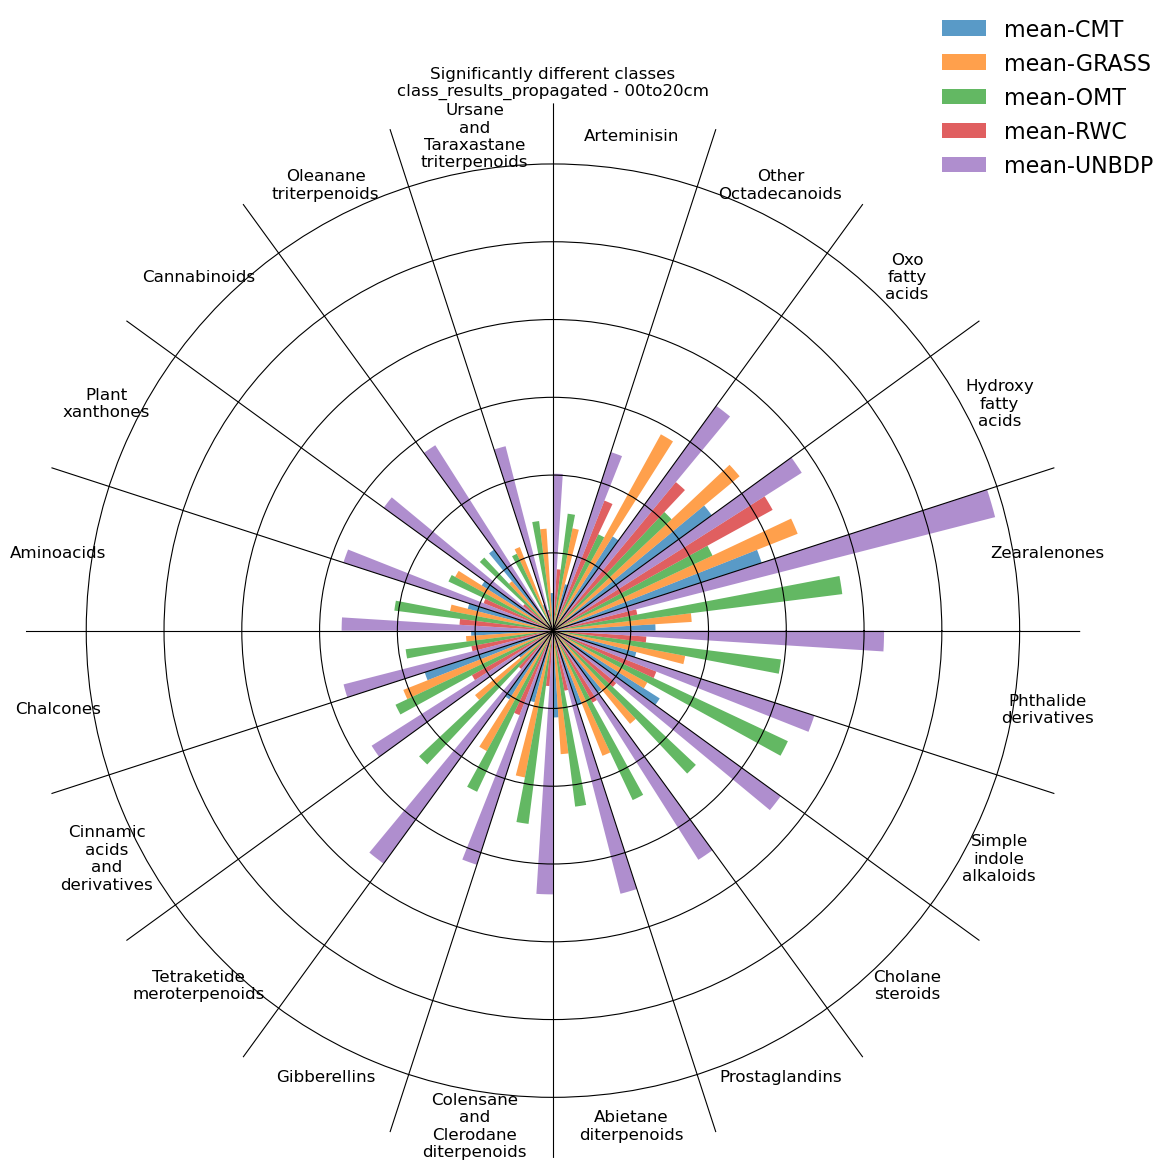

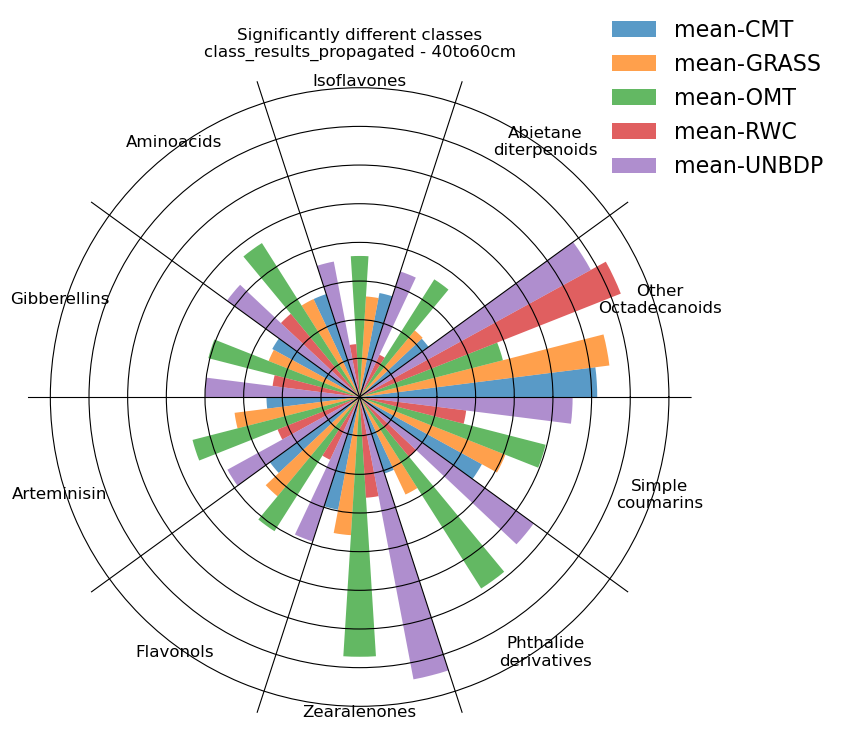

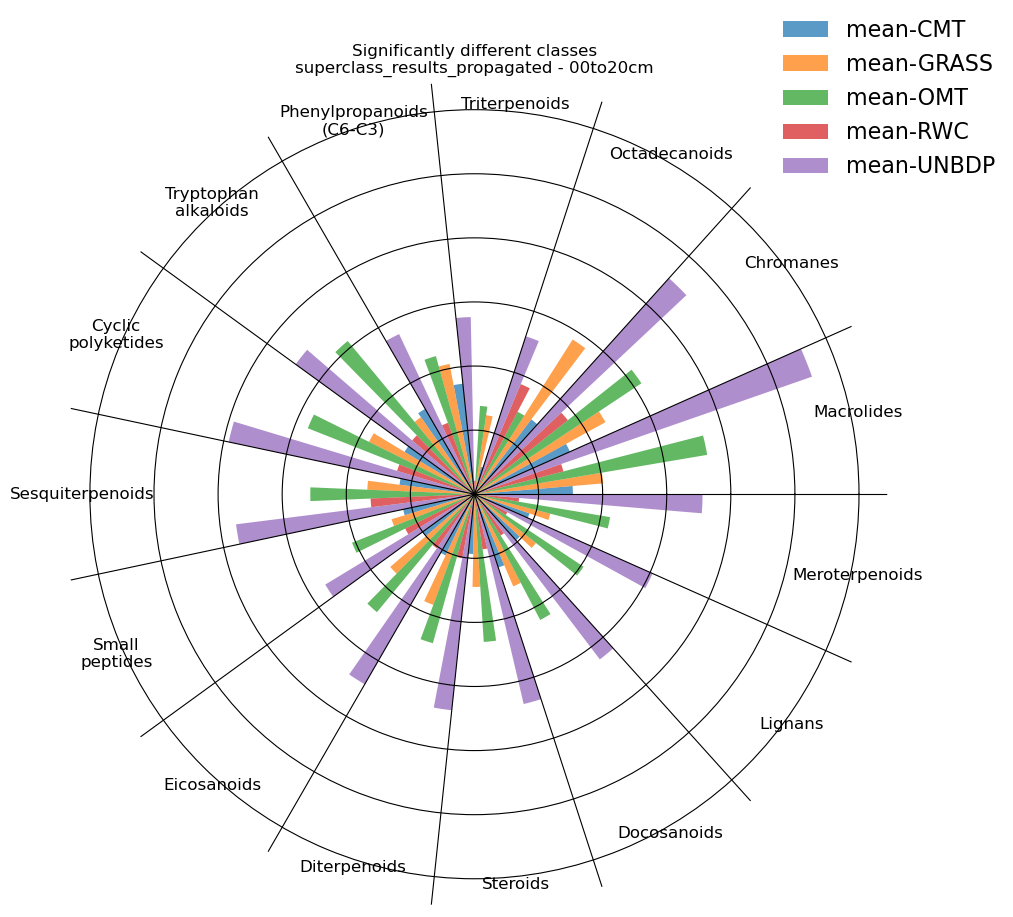

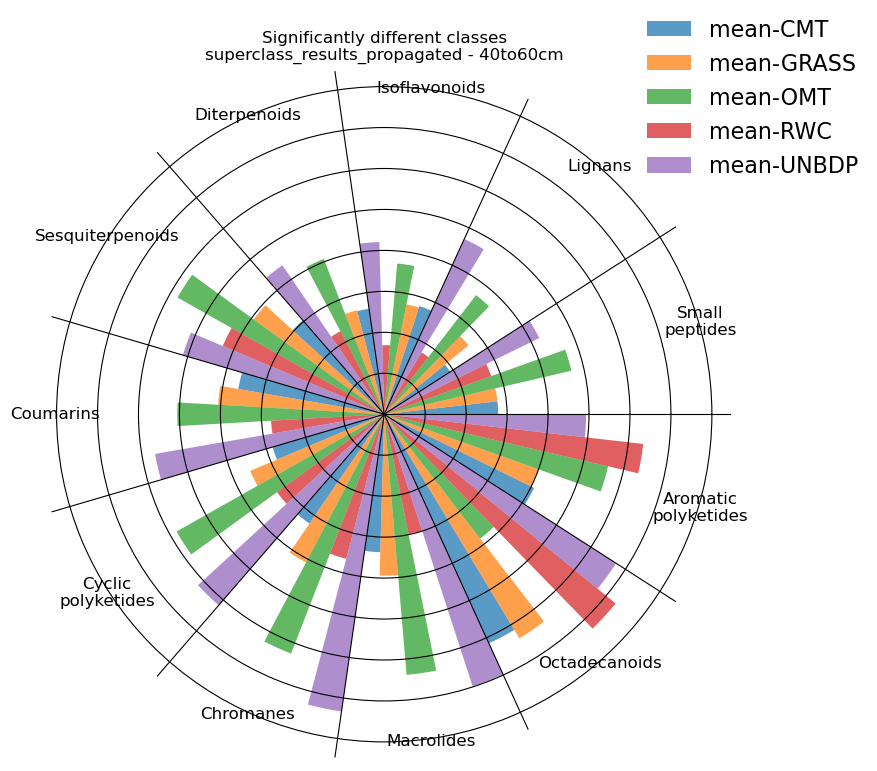

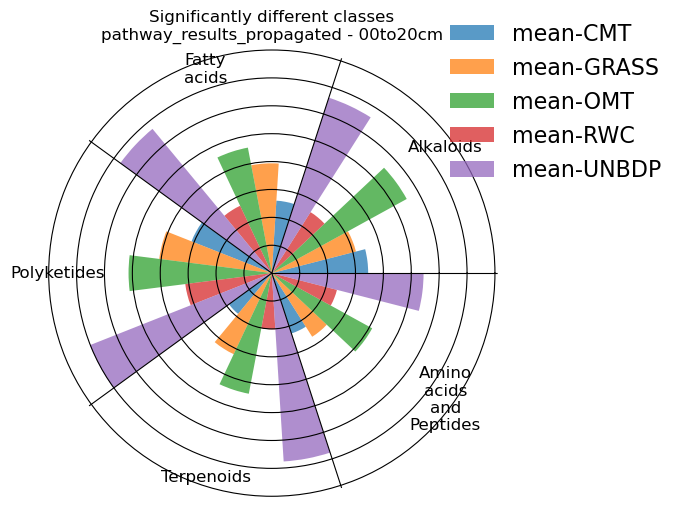

In [83]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.cluster.hierarchy import linkage, dendrogram
# Create the polar plot

def order_similar_rows(cluster_df):
    # Calculate the pairwise distances between rows
    # cols = [c for c in cluster_df.columns]# if ('deciduousforests' in c) | ('coniferousforests' in c)]
    distances = cluster_df.values

    # Perform hierarchical clustering
    Z = linkage(distances, method='average', metric='euclidean')

    # Get the order of the rows based on the clustering
    order = dendrogram(Z, no_plot=True)['leaves']

    # Reorder the rows of cluster_df
    cluster_df = cluster_df.iloc[order]

    # Show the reordered cluster_df
    return cluster_df#[cols]

def make_polar_structural_cluster_plot(cluster_df):
    cluster_df = order_similar_rows(cluster_df)
    s = cluster_df.shape[0]/20*7 + 5
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(s, s), subplot_kw={'projection': 'polar'})

    # Define the angles for each side of the polygons
    angles = np.linspace(0, 2 * np.pi, cluster_df.shape[0] + 1)[:-1]
    shift_amount = np.diff(angles)[0] / cluster_df.shape[1]
    for iii in range(cluster_df.shape[1]):
        # Define the lengths of the bars
        bar_lengths = cluster_df.values[:, iii]
        # Plot the bars
        ax.bar(angles + iii * shift_amount, bar_lengths*1, width=shift_amount, align='edge', alpha=0.74, label=cluster_df.columns[iii].replace('Quant: ',''))

    # Set the labels for each side of the polygons
    ax.set_xticks(angles)
    ax.set_xticklabels(['' for i in range(cluster_df.shape[0])])

    # Set the title of the plot
    tick_labels = ax.xaxis.get_ticklabels()

    m = ax.get_ylim()[1]*1.1
    ax.set_ylim(0, m)



    counter = 0
    for i, row in cluster_df.iterrows():
        my_angle = angles[counter] + shift_amount* cluster_df.shape[1]/2
        # my_angle = angles[counter] + shift_amount*2
        # my_angle = my_angle * 180/np.pi - 90
        # my_angle = my_angle * 180/np.pi
        my_angle = 0
        # ax.text(angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1.11, '%s'%i, ha='center', va='center', fontsize=12, rotation=my_angle)#angles[counter]*180/4/np.pi)
        my_text = '%s'%i
        my_text = my_text.replace(' ','\n')
        ax.text(angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 0.95, my_text, ha='center', va='center', fontsize=12, rotation=my_angle)#angles[counter]*180/4/np.pi)


        counter += 1

    ax.spines['polar'].set_visible(False)
    ax.grid(color='black')
    # Hide the y tick labels
    ax.set_yticklabels([])

    # Position the legend outside of the plot area
    ax.legend(bbox_to_anchor=(0.85, 1.1), loc='upper left',fontsize=16,frameon=False)

    plt.tight_layout()
    return ax


unique_classes = stats_out['class_level'].unique()
# unique_values = [u for u in unique_values is u!=None]
for uv in unique_classes:
    for depth_val in level1_values:
        idx = (stats_out['p-corr']<0.05) & (stats_out['class_level']==uv) & (stats_out['number_of_nodes']>10) & (stats_out['depth_selection']==depth_val)
        cluster_df = stats_out[idx].copy()
        cols = [ 'compound_class',  'mean-CMT', 'mean-GRASS', 'mean-OMT',
        'mean-RWC', 'mean-UNBDP']
        cluster_df = cluster_df[cols]
        cluster_df.drop_duplicates('compound_class',inplace=True)
        cluster_df.set_index('compound_class',inplace=True)
        if cluster_df.shape[0]>1:
            ax = make_polar_structural_cluster_plot(cluster_df)
            ax.set_title('Significantly different classes\n%s - %s'%(uv,depth_val))
    # plt.savefig('../data/structural_clusters_%s.png'%uv)
    # plt.close()


In [77]:
stats_out.columns

Index(['Contrast', 'A', 'B', 'Paired', 'Parametric', 'T', 'dof', 'alternative',
       'p-unc', 'p-corr', 'p-adjust', 'BF10', 'hedges', 'depth_selection',
       'class_level', 'compound_class', 'number_of_nodes',
       'total_nodes_for_class', 'mean-CMT', 'mean-GRASS', 'mean-OMT',
       'mean-RWC', 'mean-UNBDP', 'median-CMT', 'median-GRASS', 'median-OMT',
       'median-RWC', 'median-UNBDP', 'std_dev-CMT', 'std_dev-GRASS',
       'std_dev-OMT', 'std_dev-RWC', 'std_dev-UNBDP', 'standard_error-CMT',
       'standard_error-GRASS', 'standard_error-OMT', 'standard_error-RWC',
       'standard_error-UNBDP'],
      dtype='object')

In [76]:
idx = (stats_out['A']=='CMT') & (stats_out['B']=='OMT') & (stats_out['p-corr']<0.05) & (stats_out['class_level']=='pathway_results_propagated') & (stats_out['number_of_nodes']>10)#class_results_propagated
stats_out[idx].sort_values('depth_selection')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,...,std_dev-CMT,std_dev-GRASS,std_dev-OMT,std_dev-RWC,std_dev-UNBDP,standard_error-CMT,standard_error-GRASS,standard_error-OMT,standard_error-RWC,standard_error-UNBDP
122,environment,CMT,OMT,False,True,-3.850683,28.0,two-sided,0.000626,0.006262,...,0.057285,0.063124,0.112227,0.024893,0.131626,0.014791,0.016299,0.028977,0.011132,0.058865
154,environment,CMT,OMT,False,True,-3.719341,28.0,two-sided,0.000887,0.008871,...,0.054819,0.058986,0.087201,0.024769,0.103797,0.014154,0.015230,0.022515,0.011077,0.046420
381,environment,CMT,OMT,False,True,-3.111750,28.0,two-sided,0.004253,0.042527,...,0.033886,0.029132,0.108942,0.024611,0.072545,0.008749,0.007522,0.028129,0.011006,0.032443
156,environment,CMT,OMT,False,True,-3.710810,28.0,two-sided,0.000907,0.009073,...,0.024140,0.036470,0.096574,0.015876,0.072609,0.006233,0.009417,0.024935,0.007100,0.032472


In [33]:
idx = (stats_out['A']=='CMT') & (stats_out['B']=='OMT') & (stats_out['p-corr']<0.05)
stats_out[idx].sort_values('depth_selection')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges,depth_selection,class_level,compound_class,number_of_nodes,total_nodes_for_class
1,environment,CMT,OMT,False,True,-4.716093,28.0,two-sided,0.000060,0.000603,bonferroni,323.097,-1.675531,00to20cm,superclass_results_propagated,Eicosanoids,835,835
1,environment,CMT,OMT,False,True,-3.999825,28.0,two-sided,0.000420,0.004204,bonferroni,62.832,-1.421056,00to20cm,superclass_results_propagated,Macrolides,15,15
1,environment,CMT,OMT,False,True,-3.955932,28.0,two-sided,0.000473,0.004729,bonferroni,57.015,-1.405462,00to20cm,superclass_results_propagated,Diterpenoids,118,118
1,environment,CMT,OMT,False,True,-3.766051,28.0,two-sided,0.000784,0.007840,bonferroni,37.654,-1.338001,00to20cm,superclass_results_propagated,Triterpenoids,78,78
1,environment,CMT,OMT,False,True,-3.750548,28.0,two-sided,0.000817,0.008168,bonferroni,36.415,-1.332493,00to20cm,superclass_results_propagated,Steroids,57,57
1,environment,CMT,OMT,False,True,-3.479695,28.0,two-sided,0.001662,0.016619,bonferroni,20.52,-1.236264,00to20cm,superclass_results_propagated,Cyclic polyketides,23,23
1,environment,CMT,OMT,False,True,-3.299197,28.0,two-sided,0.002646,0.026459,bonferroni,14.181,-1.172137,00to20cm,superclass_results_propagated,Tryptophan alkaloids,27,27
1,environment,CMT,OMT,False,True,-3.285378,28.0,two-sided,0.002741,0.027409,bonferroni,13.792,-1.167228,00to20cm,superclass_results_propagated,Sesquiterpenoids,92,92
1,environment,CMT,OMT,False,True,-3.232312,28.0,two-sided,0.003137,0.031374,bonferroni,12.402,-1.148374,00to20cm,superclass_results_propagated,Meroterpenoids,37,37
1,environment,CMT,OMT,False,True,-3.179563,28.0,two-sided,0.003586,0.035857,bonferroni,11.17,-1.129634,00to20cm,superclass_results_propagated,Chromanes,16,16


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Assuming `t` is your DataFrame with a MultiIndex
linestyles = ['-', '--']  # Define the linestyles you want to use
# stacked bar chart for each environment/depth.  Each stack will be a compound class.
class_level = 'pathway_results_propagated'
# class_level='superclass_results'
# class_level='class_results_propagated'

df[class_level] = df[class_level].fillna('Unknown')
u_class = df[class_level].unique()
plotted_count = 0
for u in u_class:
    my_nodes = df[df[class_level]==u]['node_id'].tolist()
    my_nodes = list(set(my_nodes) & set(norm_sample.columns))
    if len(my_nodes)>min_nodes:
        plotted_count += 1
nrows=int(np.ceil(plotted_count/4))
fig,ax = plt.subplots(nrows=nrows,ncols=4,figsize=(24,nrows*3),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0
for u in u_class:
    my_nodes = df[df[class_level]==u]['node_id'].tolist()
    my_nodes = list(set(my_nodes) & set(norm_sample.columns))
    if len(my_nodes)<min_nodes:
        continue
    t = d_sample[my_nodes]
    t_melted = t.reset_index().melt(id_vars=t.index.names)
    aov = pg.anova(data=t_melted, dv='value', between=['depth', 'environment'], detailed=True)

    if aov['p-unc'].min()<0.05:
        # sns.violinplot(t_melted,x='environment',y='value',hue='depth',ax=ax[counter],split=True)
        sns.boxplot(t_melted,x='environment',y='value',hue='depth',ax=ax[counter])
        # ax[counter].set_ylim(-0.1,1.1)
        p_str = ','.join(['%.2e'%f for f in aov['p-unc'].to_list()[:-1]])
        ax[counter].set_title('%s: %d nodes\np-vals: %s'%(u,len(my_nodes),p_str))
        ax[counter].get_legend().remove()
        counter += 1


# t_melted = t.reset_index().melt(id_vars=t.index.names)
# t_melted

In [ ]:
','.join(['%.2e'%f for f in aov['p-unc'].to_list()[:-1]])

In [ ]:
# and 'value' is the dependent variable
aov = pg.anova(data=t_melted, dv='value', between=['depth', 'environment'], detailed=True)

aov['p-unc'].min()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Assuming `t` is your DataFrame with a MultiIndex
linestyles = ['-', '--']  # Define the linestyles you want to use
# stacked bar chart for each environment/depth.  Each stack will be a compound class.
class_level = 'pathway_results_propagated'
class_level='superclass_results_propagated'

df[class_level] = df[class_level].fillna('Unknown')
u_class = df[class_level].unique()
nrows=int(np.ceil(len(u_class)))
fig,ax = plt.subplots(nrows=nrows,ncols=3,figsize=(14,nrows*3),sharex=True,sharey=False)
ax = ax.flatten()
counter = 0
for u in u_class:
    my_nodes = df[df[class_level]==u]['node_id'].tolist()
    my_nodes = list(set(my_nodes) & set(norm_sample.columns))
    t = norm_sample[my_nodes]
    # t = t.T
    # sns.kdeplot(t)



    # Get unique values for each level
    level1_values = t.index.get_level_values(0).unique()
    level2_values = t.index.get_level_values(1).unique()

    for level1 in level1_values:
        linestyle = linestyles[0] if level1 == '00to20cm' else linestyles[1]
        colors = itertools.cycle(sns.color_palette())  # Define the colors you want to use
        for level2 in level2_values:
            color = next(colors)
            subset = t.loc[(level1, level2)]
            sns.kdeplot(subset, linestyle=linestyle, color=color, label=f'{level1}, {level2}',ax=ax[counter],cut=0)
        
    ax[counter].set_title(u)
    # Add a legend

    counter += 1

legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Move the legend outside of the plot area
legend.set_bbox_to_anchor((1.05, 0.5))
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Normalize the columns of d_sample
scaler = StandardScaler()
d_sample_scaled = scaler.fit_transform(d_sample)

# d_sample_scaled = d_sample.apply(lambda x: np.log2(x / d_sample.loc[('d0', 'Sterile', 'NA')]),axis=1)
# d_sample_scaled = d_sample_scaled.drop(('d0', 'Sterile', 'NA'))

# Compute the distance matrix
d_sample_dist = sch.distance.pdist(d_sample_scaled.T)
d_sample_linkage = sch.linkage(d_sample_dist, method='average')

# Form clusters from the hierarchical clustering
max_d = 3
  # max_d is the maximum distance to form cluster. You can adjust this value
clusters = fcluster(d_sample_linkage, max_d, criterion='distance')
n = len(pd.unique(clusters))
print(n)
# Create a DataFrame from the scaled data
d_sample_scaled_df = pd.DataFrame(d_sample_scaled.T, index=d_sample.columns, columns=d_sample.index)



# Add the cluster labels to the DataFrame
# d_sample_scaled_df['cluster'] = clusters
min_nodes=9
cols = d_sample_scaled_df.T.columns
num_rows = 0
for my_cluster in pd.unique(clusters):
    my_cols = cols[clusters==my_cluster]
    if len(my_cols)<min_nodes:
        continue
    num_rows += 1
print(num_rows)
num_rows = int(np.ceil(num_rows / 5))
fig,ax = plt.subplots(figsize=(20, 4*num_rows),ncols=5,nrows=num_rows,sharey=False,sharex=True)
ax = ax.flatten()
counter = 0
save_clusters = []
for my_cluster in pd.unique(clusters):
    my_cols = cols[clusters==my_cluster]
    if len(my_cols)<min_nodes:
        continue
    save_clusters.append(my_cluster)
    d = d_sample_scaled_df.T[my_cols].copy()
    d.reset_index(inplace=True,drop=False)
    d = d.melt(id_vars=['depth','environment'], var_name='node_id', value_name='value')
    # d['community-supplement'] = d['community-supplement'].astype(str)
    sns.boxplot(x='environment', y='value', hue='depth',data=d,ax=ax[counter])
    # ax[counter].set_title(g,fontsize=14)
    # if g=='NatCom':
    ax[counter].set_ylabel("Cluster %d: %d nodes"%(my_cluster,len(my_cols)))
    counter += 1
plt.tight_layout()
plt.show()

In [ ]:

import matplotlib.cm as cm
min_val = 0.03
counter = 0
for cluster_col in ['pathway_results_propagated','superclass_results_propagated','class_results_propagated']:
    t = []
    fig,ax = plt.subplots(figsize=(12,2))#,nrows=1,ncols=1,sharex=True)

    for my_cluster in save_clusters:
        my_cols = cols[clusters==my_cluster]
        temp = df.loc[df['node_id'].isin(my_cols),cluster_col]
        temp.fillna('Unknown',inplace=True)
        temp = temp.value_counts()
        temp = temp / temp.sum()
        temp = temp[temp>min_val]
        temp = temp / temp.sum()
        temp = temp.to_frame()
        temp['cluster'] = my_cluster
        t.append(temp)
    t = pd.concat(t)
    t.reset_index(inplace=True,drop=False)
    t = pd.pivot_table(t,index=cluster_col,columns='cluster',values='count',fill_value=0)
    t = t[save_clusters]
# New code for using a colormap
    if t.shape[0]>10:
        colormap = cm.get_cmap('tab20')
    else:
        colormap = cm.get_cmap('tab10')
    colors = [colormap(i) for i in np.linspace(0, 1, t.shape[0])]

    t.T.plot(kind='bar', stacked=True, figsize=(10, 7),ax=ax, color=colors)
    ax.set_title('%s greater than %d percent'%(cluster_col,100*min_val))
    legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Move the legend outside the plot area
    legend.set_bbox_to_anchor((1.05, 0.5))
    

plt.show()



In [ ]:

# d = out.pivot_table(columns='node_id',index=['depth','environment'],values='peak_area',aggfunc='mean',fill_value=300)
# d.reset_index(inplace=True,drop=False)
# d.shape,len(cluster_strings),Z.shape
out

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
# d = setup_dataframe(out)
d = out.pivot_table(index='node_id',columns=['environment','depth'],values='peak_area',aggfunc='mean',fill_value=300)
d.columns = [f"{index[1]}-{index[0]}" for index in d.columns]

cluster_strings = list(d.columns)#[os.path.basename(c).split('_')[12] for c in d.index]

# Perform hierarchical clustering
Z = linkage(d.T.apply(lambda x: x**0.5), method='ward', metric='euclidean')
import matplotlib.pyplot as plt
# Plot the dendrogram
plt.figure(figsize=(20, 3))

clusters = fcluster(Z, 4e4, criterion='distance')
# d['cluster'] = clusters
# cluster_strings = [f"{index[1]}-{index[0]} Cluster {cluster}" for index, cluster in zip(d.index, d['cluster'])]
# cluster_strings = [f"{index} Cluster {cluster}" for index, cluster in zip(d.index, d['cluster'])]

dendrogram(Z, labels=cluster_strings, leaf_font_size=14,color_threshold=4e4,)
# Set plot title and labels
# plt.title("Dendrogram with Depth and Environment Labels")
# plt.xlabel("Samples", fontsize=14)
plt.ylabel("Distance", fontsize=14)

# Set y tick label fontsize
plt.yticks(fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)


# Show the plot
plt.show()


In [ ]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])
# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)

# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# p = temp[pd.notna(temp['smiles_identity'])]

# p.sort_values('fold_change',ascending=False,inplace=True)
# top_10 = p.head(20)
# bottom_10 = p.tail(20)

# top_mols = [Chem.MolFromSmiles(smiles) for smiles in top_10['smiles_identity']]
# bottom_mols = [Chem.MolFromSmiles(smiles) for smiles in bottom_10['smiles_identity']]
# mols = top_mols + bottom_mols
# image = Draw.MolsToGridImage(mols, subImgSize=(200,200),molsPerRow=10,maxMols=1000,useSVG=True)
# image

In [ ]:
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])

# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# # p = d[pd.notna(d['smiles_identity'])]
# p = temp.copy()
# fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(15,5),sharey=True,sharex=True)
# ax.vlines(p['precursor_mz'], 0, p[c1]**0.5)
# ax.vlines(p['precursor_mz'], 0, -1*(p[c2]**0.5))
# # ax[1].vlines(p['precursor_mz'], 0, p['fold_change'])
# # ax[2].vlines(p['precursor_mz'], 0, ymax=-1*(p[2]**0.5))

# # ax.set_ylim(-50000,50000)
# ax.grid(True)
# ax.set_xlim(50,650)


In [ ]:
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])

# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# # p = d[pd.notna(d['smiles_identity'])]
# p = temp.copy()
# fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(15,11),sharey=True,sharex=True)
# ax[0].vlines(p['precursor_mz'], 0, p['fold_change'])


# p = temp[pd.notna(temp['smiles_identity'])]
# ax[1].vlines(p['precursor_mz'], 0, p['fold_change'])
# # ax[2].vlines(p['precursor_mz'], 0, ymax=-1*(p[2]**0.5))


# # for a in ax:
#     # a.set_xlim(270,330)


In [ ]:

mcs_structural_cluster_number

In [ ]:
# mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

# temp = pd.DataFrame({'cluster':mcs_structural_cluster_number})
# temp = pd.merge(temp,pd.DataFrame({'smiles':smiles_identity}),left_index=True,right_index=True)
# temp.fillna('',inplace=True)
# sig_out = []
# val_out = []
# for i in temp['cluster'].unique():
#     df = pd.merge(out,temp,left_on='node_id',right_index=True)
#     # df = df[df['depth']!='litter']
#     # df = df[df['depth']!='b']
#     # df = df[(df['environment']=='coniferousforests') | (df['environment']=='grasses') ]
#     df = df[df['cluster']==i]
#     cols = ['environment', 'depth','peak_area','filename','node_id']
#     df = df[cols]
#     # filename_mapping = {f: i+1 for i, f in enumerate(df['filename'].unique())}
#     # df['filename'] = df['filename'].map(filename_mapping)

#     # node_id_mapping = {f: i+1 for i, f in enumerate(df['node_id'].unique())}
#     # df['node_id'] = df['node_id'].map(node_id_mapping)



#     df = pd.pivot_table(df,values='peak_area',index=['filename','environment','depth'],columns=['node_id'],fill_value=300)
#     df = df.mean(axis=1).to_frame()
#     df.reset_index(inplace=True,drop=False)
#     df.rename(columns={0:'peak_area'},inplace=True)
#     anova_result = pg.anova(data=df, dv='peak_area', between=['environment', 'depth'])#, subject='filename')
#     anova_result['structural_cluster'] = i
#     sig_out.append(anova_result)
#         # THERE IS A PROBLEM HERE.  OUT SHOULD BE FILTERED TO ONLY STRUCTURAL CLUSTERS

#     v = out.groupby(['environment','depth'])['peak_area'].mean().to_frame().reset_index()
#     v['structural_cluster'] = i
#     val_out.append(v)
# sig_out = pd.concat(sig_out)
# val_out = pd.concat(val_out)
# sig_out = pd.pivot_table(sig_out,values='p-unc',index=['structural_cluster'],columns=['Source'])
# sig_out = sig_out[sig_out.min(axis=1)<0.05]
# val_out = val_out.pivot_table(index='structural_cluster',columns=['environment','depth'],values='peak_area')
# val_out.columns = ['_'.join(c) for c in val_out.columns]
# val_out.reset_index(inplace=True,drop=False)
# sig_out = pd.merge(sig_out,val_out,left_index=True,right_on='structural_cluster',how='inner')

In [ ]:
node_data = pd.pivot_table(out,index=['node_id'],columns=['sampletype','depth'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['_'.join(c) for c in node_data.columns]

node_data.columns = ['Quant: %s'%c for c in node_data.columns]
backup_G = G.copy()
nx.set_node_attributes(backup_G, node_data.to_dict('index'))
# nx.write_graphml(backup_G,'../data/network_omt-potting.graphml')

In [ ]:
node_data = pd.pivot_table(out,index=['node_id'],columns=['depth','environment'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['%s-%s'%(c[1],c[0]) for c in node_data.columns]

# node_data = node_data.apply(lambda  x: np.log10(x+1),axis=1)
# s = node_data.sum(axis=0).values
# m = s.mean()
# node_data.values[:,:] = m * (node_data.values[:,:]/s)
# node_data.columns = [c.split('/')[-1].split('_')[12] for c in node_data.columns]

# node_data.to_csv('../data/log10_averages_treatments.csv')
node_data
node_data.columns = ['Quant: %s'%c for c in node_data.columns]

n = node_data.copy()
m = n.min(axis=1)
m = n.values - m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)

m = n.max(axis=1)
m = n.values / m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)


original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
mcs_structural_pattern = nx.get_node_attributes(G, 'mcs_structural_pattern')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
# temp = {}
# for c in n.columns:
    # temp[c] = nx.get_node_attributes(backup_G, c)

temp = pd.merge(n,pd.DataFrame({'cluster_id':mcs_structural_cluster_number}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'cluster_pattern':mcs_structural_pattern}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
cols = [c for c in temp.columns if 'Quant' in c]
cluster_df = temp.groupby(['cluster_id','cluster_pattern'])[cols].mean()
identity_df = temp.groupby(['cluster_id','cluster_pattern','smiles_identity'])[cols].mean()
cluster_df

In [ ]:
import umap
node_data = pd.pivot_table(out,index=['node_id'],columns=['depth','environment'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['%s-%s'%(c[1],c[0]) for c in node_data.columns]
# Reduce dimensionality using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(node_data.T)


In [ ]:
colors = [col.split('-')[1] for col in node_data.columns]
shapes = [col.split('-')[0] for col in node_data.columns]
pd.unique(colors)

In [ ]:

shape_mapping = {'CMT':'o', 'GRASS':'s', 'OMT':'D', 'RWC':'^', 'UNBDP':'*'}
    
    # 'Quant: coniferousforests':'o', 'Quant: deciduousforests':'s',
    # 'Quant: desertshrubs':'D', 'Quant: grasses':'^', 'Quant: mixedforests':'v',
    # 'Quant: tundra':'*'}

colors = [col.split('-')[1] for col in node_data.columns]
shapes = [col.split('-')[0] for col in node_data.columns]
color_mapping = {'00to20cm':'b', '40to60cm':'r'}
# 'a': 'purple', 'b': 'blue', 'c': 'cyan'}  # Add your color mapping here

# Convert categorical values to actual shapes
actual_shapes = [shape_mapping[shape] for shape in shapes]

# Convert categorical values to actual colors
actual_colors = [color_mapping[color] for color in colors]


# fig, ax = plt.subplots(figsize=(5, 5))
# for i in range(embedding.shape[0]):
#     ax.scatter(embedding[i, 0], embedding[i, 1],s=50, c=actual_colors[i], marker=actual_shapes[i], label='%s-%s' % (shapes[i], colors[i]))

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig, ax = plt.subplots(figsize=(5, 5))

# Group the markers by shape
shape_groups = node_data.columns.to_series().groupby(shapes)

for shape, group in shape_groups:
    # Get the indices of the markers with the same shape
    indices = [i for i, col in enumerate(node_data.columns) if col.split('-')[0] == shape]
    
    # Get the colors of the markers with the same shape
    shape_colors = [actual_colors[i] for i in indices]
    
    # Get the coordinates of the markers with the same shape
    shape_coords = embedding[indices]
    
    # Draw shaded regions around markers with the same shape
    ax.scatter(shape_coords[:, 0], shape_coords[:, 1], s=50, c=shape_colors, marker=shape_mapping[shape], label=shape)
    ax.fill(shape_coords[:, 0], shape_coords[:, 1], facecolor='none', edgecolor='gray', alpha=0.2)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Scatter Plot')
plt.show()


# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.title('UMAP Scatter Plot')
# plt.show()



In [ ]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)
temp = cluster_df.copy()
# cols = [c for c in temp.columns if 'litter' not in c]
# temp = temp[cols]
temp.reset_index(inplace=True,drop=False)
temp.set_index('cluster_id',inplace=True,drop=True)
temp.drop(columns=['cluster_pattern'],inplace=True)
temp = temp[temp.index.isin(sig_out.loc[sig_out['environment']<0.05,'structural_cluster'].values)].copy()

num_unique_clusters = temp.shape[0]


# temp.reset_index(inplace=True,drop=True)
temp.columns = [c.replace('Quant: ','') for c in temp.columns]
# temp = temp.apply(lambda x: x/x.sum(),axis=1)
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,20))
                      
sns.clustermap(temp,cmap='jet',method='ward')
#     ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
#     counter = 0
#     for i, row in d.iterrows():

#         mol = Chem.MolFromSmiles(row['smiles_identity'])
#         d2d = Draw.MolDraw2DCairo(120, 120)
#         dopts = d2d.drawOptions()
#         dopts.setBackgroundColour((0, 0, 0, 0))
#         im = show_mol(d2d, mol)

#         imagebox = OffsetImage(im, zoom=0.8)
#         ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
#         counter += 1
#     c += 1
#     # if c>6:
#         # break
    
# plt.tight_layout()

# # Set the x-axis labels for the bottom row of subplots
# for i in range(n_cols):
#     ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# # Set the x-axis label for the entire figure
# # fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

# plt.tight_layout()
# fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')

# cluster_df

In [ ]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

num_unique_clusters = identity_df.index.get_level_values('cluster_id').nunique()
print(num_unique_clusters)
n_cols = 4
n_rows = int(np.ceil(num_unique_clusters/n_cols))

fig,ax = plt.subplots(nrows=n_rows,ncols=4,figsize=(n_rows*4,n_cols*14),sharex=True,sharey=False)
                      
ax = ax.flatten()
for _,d in identity_df.reset_index(drop=False).groupby('cluster_id'):
    
    sns.heatmap(d[cols].values,ax=ax[c],cmap='viridis')
    ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
    counter = 0
    for i, row in d.iterrows():

        mol = Chem.MolFromSmiles(row['smiles_identity'])
        d2d = Draw.MolDraw2DCairo(120, 120)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        im = show_mol(d2d, mol)

        imagebox = OffsetImage(im, zoom=0.8)
        ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
        counter += 1
    c += 1
    # if c>6:
        # break
    
plt.tight_layout()

# Set the x-axis labels for the bottom row of subplots
for i in range(n_cols):
    ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# Set the x-axis label for the entire figure
# fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

plt.tight_layout()
fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')


In [ ]:
cluster_df

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the pairwise distances between rows
# cols = [c for c in cluster_df.columns]# if ('deciduousforests' in c) | ('coniferousforests' in c)]
distances = cluster_df.values

# Perform hierarchical clustering
Z = linkage(distances, method='average', metric='euclidean')

# Get the order of the rows based on the clustering
order = dendrogram(Z, no_plot=True)['leaves']

# Reorder the rows of cluster_df
cluster_df = cluster_df.iloc[order]

# Show the reordered cluster_df
cluster_df#[cols]


In [ ]:
cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
temp = cluster_df[cols].copy()
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0
for depth in ['-a','-b','-c','-litter']:
    cols = [c for c in temp.columns if depth in c]
    X = temp[cols].values
    idx = np.argsort(X[:,0])
    X = X[idx,:]
    ax[counter].plot(X[:,0],X[:,1],'.',label=depth)
    ax[counter].set_title(depth)
    counter += 1
# ax.legend()

In [ ]:
cluster_df.shape

In [ ]:
import pingouin as pg

# Assuming you have a DataFrame called 'data' with columns: 'Metabolite', 'Treatment', 'Timepoint', and 'Value'
# 'Metabolite' column contains the names of the metabolites
# 'Treatment' column contains the treatment groups (e.g., 'Treatment A', 'Treatment B')
# 'Timepoint' column contains the timepoints (e.g., 'Timepoint 1', 'Timepoint 2')
# 'Value' column contains the observed values for each metabolite, treatment, and timepoint
data = {
    'Gene': [1,1,2,2,1,1,2,2],
    'Subject': ['Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2'],
    'Treatment': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
    'Timepoint': ['T1', 'T1', 'T1', 'T1', 'T2', 'T2', 'T2', 'T2'],
    'Value': [10, 12, 15, 14, 18, 20, 22, 24]
}

df = pd.DataFrame(data)



anova_result = pg.rm_anova(data=df, dv='Value', within=['Treatment', 'Timepoint'], subject='Subject')

# Print ANOVA results
print("Repeated Measures ANOVA Results:")
print(anova_result)


In [ ]:
cluster_df

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit import Chem
from rdkit.Chem import Draw
# Create the polar plot
def make_polar_structural_cluster_plot(cluster_df,file_str=''):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), subplot_kw={'projection': 'polar'})

    # Define the angles for each side of the polygons
    angles = np.linspace(0, 2 * np.pi, cluster_df.shape[0] + 1)[:-1]
    shift_amount = np.diff(angles)[0] / cluster_df.shape[1]
    for iii in range(cluster_df.shape[1]):
        # Define the lengths of the bars
        bar_lengths = cluster_df.values[:, iii]
        # Plot the bars
        ax.bar(angles + iii * shift_amount, bar_lengths*1, width=shift_amount, align='edge', alpha=0.74, label=cluster_df.columns[iii].replace('Quant: ',''))

    # Set the labels for each side of the polygons
    ax.set_xticks(angles)
    ax.set_xticklabels(['' for i in range(cluster_df.shape[0])])

    # Set the title of the plot
    tick_labels = ax.xaxis.get_ticklabels()

    m = ax.get_ylim()[1]*1.1
    ax.set_ylim(0, m)

    from PIL import Image
    from io import BytesIO
    def show_mol(d2d,mol,legend='',highlightAtoms=[]):
        d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
        d2d.FinishDrawing()
        bio = BytesIO(d2d.GetDrawingText())
        return Image.open(bio)

    counter = 0
    for i, row in cluster_df.iterrows():
        mol = Chem.MolFromSmarts(i[1])
        s = Chem.MolToSmiles(mol)
        mol = Chem.MolFromSmiles(s)
        d2d = Draw.MolDraw2DCairo(40, 40)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        if mol is not None:
            im = show_mol(d2d, mol)

            imagebox = OffsetImage(im, zoom=0.8)
            ax.add_artist(AnnotationBbox(imagebox, (angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1), frameon=False))
        # if np.cos(angles[counter]) < 0:
        # my_angle = angles[counter] + shift_amount*2 - np.pi
        # else:
        my_angle = angles[counter] + shift_amount* cluster_df.shape[1]/2
        # my_angle = angles[counter] + shift_amount*2
        my_angle = my_angle * 180/np.pi - 90
        ax.text(angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1.11, '%d'%i[0], ha='center', va='center', fontsize=12, rotation=my_angle)#angles[counter]*180/4/np.pi)


        counter += 1

    ax.spines['polar'].set_visible(False)
    ax.grid(color='black')
    # Hide the y tick labels
    ax.set_yticklabels([])

    # Position the legend outside of the plot area
    ax.legend(bbox_to_anchor=(0.85, 1.1), loc='upper left',fontsize=16,frameon=False)

    plt.tight_layout()
    # fig.savefig('lcms-structural_cluster_plot_%s.pdf'%file_str)#, dpi=300)

# cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
# cols = [c for c in cluster_df.columns if ('OMT' in c) | ('CMT' in c)]
# cols = [c for c in cluster_df.columns if ('40to60' in c)]
cols = [c for c in cluster_df.columns if ('00to20' in c)]
# cols = [c for c in cluster_df.columns if ('UNBDP' in c) | ('OMT' in c)]
make_polar_structural_cluster_plot(cluster_df[cols],'Quant-Century-Environment-Depth-40to60')

In [ ]:
mol

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of sides of the polygons
num_sides = bar_df.shape[0]

# Define the angles for each side of the polygons
angles = np.linspace(0, 2 * np.pi, num_sides + 1)[:-1]



# Create the polar plot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12),subplot_kw={'projection': 'polar'})
ax = ax.flatten()

for i in range(len(ax)):
    # Define the lengths of the bars
    bar_lengths = bar_df.values[:,i]
    # Plot the bars
    ax[i].bar(angles, bar_lengths, width=0.1, align='edge', color='blue', alpha=0.5)


    # Set the labels for each side of the polygons
    ax[i].set_xticks(angles)
    ax[i].set_xticklabels(['Side {}'.format(i+1) for i in range(num_sides)])

    # Set the title of the plot
    ax[i].set_title(bar_df.columns[i])

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
values = [10, 15, 7, 12, 9]

# Convert values to radians
theta = np.linspace(0.0, 2 * np.pi, len(categories), endpoint=False)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
bars = ax.bar(theta, values)

# Set the color of each bar
for bar in bars:
    bar.set_facecolor(np.random.rand(3))

# Set the labels for each category
ax.set_xticks(theta)
ax.set_xticklabels(categories)

# Set the title of the plot
ax.set_title('Circular Barchart')

# Show the plot
plt.show()
